In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import plotly.graph_objects as go
from datetime import datetime
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\nites\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
!pip install alpaca-trade-api

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv("API_KEYS.env")
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
base_url = 'https://paper-api.alpaca.markets'

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, base_url, api_version="v2")
account = api.get_account()
print(account)

Account({   'account_blocked': False,
    'account_number': 'PA2JTPIDTTJ1',
    'buying_power': '400000',
    'cash': '100000',
    'created_at': '2020-06-24T01:28:18.741414Z',
    'currency': 'USD',
    'daytrade_count': 0,
    'daytrading_buying_power': '400000',
    'equity': '100000',
    'id': 'd4a649d3-66b0-44ac-a731-c9b4e333ae3a',
    'initial_margin': '0',
    'last_equity': '100000',
    'last_maintenance_margin': '0',
    'long_market_value': '0',
    'maintenance_margin': '0',
    'multiplier': '4',
    'pattern_day_trader': False,
    'portfolio_value': '100000',
    'regt_buying_power': '200000',
    'short_market_value': '0',
    'shorting_enabled': True,
    'sma': '0',
    'status': 'ACTIVE',
    'trade_suspended_by_user': False,
    'trading_blocked': False,
    'transfers_blocked': False})


In [4]:
# Get all Assets
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
#tradeable

In [5]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df["symbol"] = pd.Series([asset.symbol for asset in assets])
#asset_info_df.sort_values("symbol", inplace=True)

# Display the first 10 asset tickers
asset_info_df.head(10)

,symbol
0,BBRC
1,AAAU
2,AACG
3,AAL
4,AAN
5,AAOI
6,AAP
7,AAT
8,AAVVF
9,AAXJ


In [6]:
# Set the ticker
ticker = input("Enter the ticker to run Technical Analysis")
#ticker = ["AAPL", "BMO", "RBC"]

# Set timeframe to "1D"
timeframe = "1D"

#Time Duration
start_time = input("Enter the start time for the data in YYYY-MM-DD format")
end_time = input("Enter the end time for the data in YYYY-MM-DD format")

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp(start_time, tz="America/New_York").isoformat()
end_date = pd.Timestamp(end_time, tz="America/New_York").isoformat()

# Get 1 year"s worth of historical data for the desired stock
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.tail()

RBC                              
                             open    high    low  close  volume
time                                                           
2020-08-25 00:00:00-04:00   98.84   99.58  98.28  99.53  492250
2020-08-26 00:00:00-04:00   99.52   99.96  98.50  99.52  252060
2020-08-27 00:00:00-04:00   99.92  100.63  99.06  99.84  436785
2020-08-28 00:00:00-04:00  100.08  100.08  98.12  99.66  366316
2020-08-31 00:00:00-04:00   99.66   99.66  98.19  98.90  372712

In [7]:
# Plotting the data as candlesticks

fig = go.Figure(data=[go.Candlestick(open=df[ticker, 'open'],
                high=df[ticker, 'high'],
                low=df[ticker, 'low'],
                close=df[ticker, 'close'])])
fig.update_layout(xaxis_rangeslider_visible=False, width=1000, height=600)
fig.show()

In [8]:
#Calculation of moving average
def MA(data, n):
    MA = pd.Series(df[ticker, "close"].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
df['MA5'] = MA(df, 5)
df['MA21'] = MA(df, 21)
df['MA252'] = MA(df, 252)

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
df['MA-Signal'][short_window:] = np.where(
    signals_df['SMA50'][short_window:] > signals_df['SMA100'][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
signals_df['Entry/Exit'] = signals_df['Signal'].diff()
df.tail()

RBC                                   MA5  \
                             open    high    low  close  volume           
time                                                                      
2020-08-25 00:00:00-04:00   98.84   99.58  98.28  99.53  492250  97.106   
2020-08-26 00:00:00-04:00   99.52   99.96  98.50  99.52  252060  97.970   
2020-08-27 00:00:00-04:00   99.92  100.63  99.06  99.84  436785  98.748   
2020-08-28 00:00:00-04:00  100.08  100.08  98.12  99.66  366316  99.354   
2020-08-31 00:00:00-04:00   99.66   99.66  98.19  98.90  372712  99.490   

                                MA21      MA252  
                                                 
time                                             
2020-08-25 00:00:00-04:00  96.046667  79.535675  
2020-08-26 00:00:00-04:00  96.423810  79.656111  
2020-08-27 00:00:00-04:00  96.680476  79.778353  
2020-08-28 00:00:00-04:00  96.997619  79.893988  
2020-08-31 00:00:00-04:00  97.327143  80.004901

In [9]:
#calculation of exponential moving average
def EMA(data, n):
    EMA = pd.Series(df[ticker, 'close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
df['EMA5'] = EMA(df, 5)
df['EMA21'] = EMA(df, 21)
df['EMA252'] = EMA(df, 252)
df.tail()

RBC                                   MA5  \
                             open    high    low  close  volume           
time                                                                      
2020-08-25 00:00:00-04:00   98.84   99.58  98.28  99.53  492250  97.106   
2020-08-26 00:00:00-04:00   99.52   99.96  98.50  99.52  252060  97.970   
2020-08-27 00:00:00-04:00   99.92  100.63  99.06  99.84  436785  98.748   
2020-08-28 00:00:00-04:00  100.08  100.08  98.12  99.66  366316  99.354   
2020-08-31 00:00:00-04:00   99.66   99.66  98.19  98.90  372712  99.490   

                                MA21      MA252       EMA5      EMA21  \
                                                                        
time                                                                    
2020-08-25 00:00:00-04:00  96.046667  79.535675  97.801780  95.765148   
2020-08-26 00:00:00-04:00  96.423810  79.656111  98.374520  96.106498   
2020-08-27 00:00:00-04:00  96.680476  79.778353  98.863013  96.445907   
2020-08-28 00:00:00-04:00  96.997619  79.893988  99.128676  96.738097   
2020-08-31 00:00:00-04:00  97.327143  80.004901  99.052450  96.934634   

                              EMA252  
                                      
time                                  
2020-08-25 00:00:00-04:00  81.539689  
2020-08-26 00:00:00-04:00  81.682549  
2020-08-27 00:00:00-04:00  81.826811  
2020-08-28 00:00:00-04:00  81.968491  
2020-08-31 00:00:00-04:00  82.103002

In [10]:
#calculation of rate of change
def ROC(data, n):  
    M = data.diff(n - 1)  
    N = data.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
df['ROC21'] = ROC(df[ticker, 'close'], 21)
df['ROC63'] = ROC(df[ticker, 'close'], 63)
df.tail()

RBC                                   MA5  \
                             open    high    low  close  volume           
time                                                                      
2020-08-25 00:00:00-04:00   98.84   99.58  98.28  99.53  492250  97.106   
2020-08-26 00:00:00-04:00   99.52   99.96  98.50  99.52  252060  97.970   
2020-08-27 00:00:00-04:00   99.92  100.63  99.06  99.84  436785  98.748   
2020-08-28 00:00:00-04:00  100.08  100.08  98.12  99.66  366316  99.354   
2020-08-31 00:00:00-04:00   99.66   99.66  98.19  98.90  372712  99.490   

                                MA21      MA252       EMA5      EMA21  \
                                                                        
time                                                                    
2020-08-25 00:00:00-04:00  96.046667  79.535675  97.801780  95.765148   
2020-08-26 00:00:00-04:00  96.423810  79.656111  98.374520  96.106498   
2020-08-27 00:00:00-04:00  96.680476  79.778353  98.863013  96.445907   
2020-08-28 00:00:00-04:00  96.997619  79.893988  99.128676  96.738097   
2020-08-31 00:00:00-04:00  97.327143  80.004901  99.052450  96.934634   

                              EMA252     ROC21      ROC63  
                                                           
time                                                       
2020-08-25 00:00:00-04:00  81.539689  8.657205  23.188316  
2020-08-26 00:00:00-04:00  81.682549  5.367920  25.245406  
2020-08-27 00:00:00-04:00  81.826811  7.354839  22.864878  
2020-08-28 00:00:00-04:00  81.968491  8.349641  21.938089  
2020-08-31 00:00:00-04:00  82.103002  4.214963  17.738095

In [11]:
#Calculation of price momentum
def MOM(data, n):   
    MOM = pd.Series(data.diff(n), name='Momentum_' + str(n))   
    return MOM
df['MOM21'] = MOM(df[ticker, 'close'], 21)
df['MOM63'] = MOM(df[ticker, 'close'], 63)
df.tail()

RBC                                   MA5  \
                             open    high    low  close  volume           
time                                                                      
2020-08-25 00:00:00-04:00   98.84   99.58  98.28  99.53  492250  97.106   
2020-08-26 00:00:00-04:00   99.52   99.96  98.50  99.52  252060  97.970   
2020-08-27 00:00:00-04:00   99.92  100.63  99.06  99.84  436785  98.748   
2020-08-28 00:00:00-04:00  100.08  100.08  98.12  99.66  366316  99.354   
2020-08-31 00:00:00-04:00   99.66   99.66  98.19  98.90  372712  99.490   

                                MA21      MA252       EMA5      EMA21  \
                                                                        
time                                                                    
2020-08-25 00:00:00-04:00  96.046667  79.535675  97.801780  95.765148   
2020-08-26 00:00:00-04:00  96.423810  79.656111  98.374520  96.106498   
2020-08-27 00:00:00-04:00  96.680476  79.778353  98.863013  96.445907   
2020-08-28 00:00:00-04:00  96.997619  79.893988  99.128676  96.738097   
2020-08-31 00:00:00-04:00  97.327143  80.004901  99.052450  96.934634   

                              EMA252     ROC21      ROC63 MOM21   MOM63  
                                                                         
time                                                                     
2020-08-25 00:00:00-04:00  81.539689  8.657205  23.188316  5.98  17.450  
2020-08-26 00:00:00-04:00  81.682549  5.367920  25.245406  7.92  18.725  
2020-08-27 00:00:00-04:00  81.826811  7.354839  22.864878  5.39  20.380  
2020-08-28 00:00:00-04:00  81.968491  8.349641  21.938089  6.66  18.400  
2020-08-31 00:00:00-04:00  82.103002  4.214963  17.738095  6.92  17.170

In [12]:
# #calculation of relative strength index
# def RSI(series, period):
#     delta = series.diff().dropna()
#     u = delta * 0
#     d = u.copy()
#     u[delta > 0] = delta[delta > 0]
#     d[delta < 0] = -delta[delta < 0]
#     u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
#     u = u.drop(u.index[:(period-1)])
#     d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
#     d = d.drop(d.index[:(period-1)])
#     rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
#     pd.stats.moments.ewma(d, com=period-1, adjust=False)
#     return 100 - 100 / (1 + rs)
# df['RSI21'] = RSI(df[ticker, 'close'], 21)
# df['RSI63'] = RSI(df[ticker, 'close'], 63)
# df['RSI252'] = RSI(df[ticker, 'close'], 252)

In [21]:
#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(window= n).min()) / (high.rolling(window= n).max() - low.rolling(window= n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(window= n).min()) / (high.rolling(window= n).max() - low.rolling(window= n).min())) * 100
 STOD = STOK.rolling(window= 3).mean()
 return STOD

df['%K21'] = STOK(df[ticker, 'close'], df[ticker, 'low'], df[ticker, 'high'], 21)
df['%D21'] = STOD(df[ticker, 'close'], df[ticker, 'low'], df[ticker, 'high'], 21)
df['%K63'] = STOK(df[ticker, 'close'], df[ticker, 'low'], df[ticker, 'high'], 63)
df['%D63'] = STOD(df[ticker, 'close'], df[ticker, 'low'], df[ticker, 'high'], 63)
df['%K252'] = STOK(df[ticker, 'close'], df[ticker, 'low'], df[ticker, 'high'], 252)
df['%D252'] = STOD(df[ticker, 'close'], df[ticker, 'low'], df[ticker, 'high'], 252)
df.tail()

RBC                                   MA5  \
                             open    high    low  close  volume           
time                                                                      
2020-08-25 00:00:00-04:00   98.84   99.58  98.28  99.53  492250  97.106   
2020-08-26 00:00:00-04:00   99.52   99.96  98.50  99.52  252060  97.970   
2020-08-27 00:00:00-04:00   99.92  100.63  99.06  99.84  436785  98.748   
2020-08-28 00:00:00-04:00  100.08  100.08  98.12  99.66  366316  99.354   
2020-08-31 00:00:00-04:00   99.66   99.66  98.19  98.90  372712  99.490   

                                MA21      MA252       EMA5      EMA21  ...  \
                                                                       ...   
time                                                                   ...   
2020-08-25 00:00:00-04:00  96.046667  79.535675  97.801780  95.765148  ...   
2020-08-26 00:00:00-04:00  96.423810  79.656111  98.374520  96.106498  ...   
2020-08-27 00:00:00-04:00  96.680476  79.778353  98.863013  96.445907  ...   
2020-08-28 00:00:00-04:00  96.997619  79.893988  99.128676  96.738097  ...   
2020-08-31 00:00:00-04:00  97.327143  80.004901  99.052450  96.934634  ...   

                          bollinger_long bollinger_short bollinger_signal  \
                                                                            
time                                                                        
2020-08-25 00:00:00-04:00            0.0            -1.0             -1.0   
2020-08-26 00:00:00-04:00            0.0            -1.0             -1.0   
2020-08-27 00:00:00-04:00            0.0            -1.0             -1.0   
2020-08-28 00:00:00-04:00            0.0            -1.0             -1.0   
2020-08-31 00:00:00-04:00            0.0             0.0              0.0   

                           close       %K21       %D21       %K63       %D63  \
                                                                               
time                                                                           
2020-08-25 00:00:00-04:00  99.53  89.341263  76.501982  94.816463  88.572488   
2020-08-26 00:00:00-04:00  99.52  89.249771  85.315645  94.771969  92.858732   
2020-08-27 00:00:00-04:00  99.84  92.177493  90.256176  96.195773  95.261402   
2020-08-28 00:00:00-04:00  99.66  90.530650  90.652638  95.394883  95.454208   
2020-08-31 00:00:00-04:00  98.90  83.577310  88.761818  92.013348  94.534668   

                               %K252      %D252  
                                                 
time                                             
2020-08-25 00:00:00-04:00  97.608048  94.726756  
2020-08-26 00:00:00-04:00  97.587517  96.704650  
2020-08-27 00:00:00-04:00  98.244533  97.813366  
2020-08-28 00:00:00-04:00  97.874962  97.902337  
2020-08-31 00:00:00-04:00  96.314547  97.478014  

[5 rows x 29 columns]

In [14]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
df['bollinger_mid_band'] = df[ticker, 'close'].rolling(window=bollinger_window).mean()
df['bollinger_std'] = df[ticker, 'close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
df['bollinger_upper_band']  = df['bollinger_mid_band'] + (df['bollinger_std'] * 1)
df['bollinger_lower_band']  = df['bollinger_mid_band'] - (df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
df['bollinger_long'] = np.where(df[ticker, 'close'] < df['bollinger_lower_band'], 1.0, 0.0)
df['bollinger_short'] = np.where(df[ticker, 'close'] > df['bollinger_upper_band'], -1.0, 0.0)
df['bollinger_signal'] = df['bollinger_long'] + df['bollinger_short']
df['close'] = df[ticker, 'close']

df.tail()



RBC                                   MA5  \
                             open    high    low  close  volume           
time                                                                      
2020-08-25 00:00:00-04:00   98.84   99.58  98.28  99.53  492250  97.106   
2020-08-26 00:00:00-04:00   99.52   99.96  98.50  99.52  252060  97.970   
2020-08-27 00:00:00-04:00   99.92  100.63  99.06  99.84  436785  98.748   
2020-08-28 00:00:00-04:00  100.08  100.08  98.12  99.66  366316  99.354   
2020-08-31 00:00:00-04:00   99.66   99.66  98.19  98.90  372712  99.490   

                                MA21      MA252       EMA5      EMA21  ...  \
                                                                       ...   
time                                                                   ...   
2020-08-25 00:00:00-04:00  96.046667  79.535675  97.801780  95.765148  ...   
2020-08-26 00:00:00-04:00  96.423810  79.656111  98.374520  96.106498  ...   
2020-08-27 00:00:00-04:00  96.680476  79.778353  98.863013  96.445907  ...   
2020-08-28 00:00:00-04:00  96.997619  79.893988  99.128676  96.738097  ...   
2020-08-31 00:00:00-04:00  97.327143  80.004901  99.052450  96.934634  ...   

                          MOM21   MOM63 bollinger_mid_band bollinger_std  \
                                                                           
time                                                                       
2020-08-25 00:00:00-04:00  5.98  17.450            96.2690      2.216977   
2020-08-26 00:00:00-04:00  7.92  18.725            96.5225      2.286802   
2020-08-27 00:00:00-04:00  5.39  20.380            96.8645      2.243333   
2020-08-28 00:00:00-04:00  6.66  18.400            97.2485      2.008215   
2020-08-31 00:00:00-04:00  6.92  17.170            97.4485      1.960634   

                          bollinger_upper_band bollinger_lower_band  \
                                                                      
time                                                                  
2020-08-25 00:00:00-04:00            98.485977            94.052023   
2020-08-26 00:00:00-04:00            98.809302            94.235698   
2020-08-27 00:00:00-04:00            99.107833            94.621167   
2020-08-28 00:00:00-04:00            99.256715            95.240285   
2020-08-31 00:00:00-04:00            99.409134            95.487866   

                          bollinger_long bollinger_short bollinger_signal  \
                                                                            
time                                                                        
2020-08-25 00:00:00-04:00            0.0            -1.0             -1.0   
2020-08-26 00:00:00-04:00            0.0            -1.0             -1.0   
2020-08-27 00:00:00-04:00            0.0            -1.0             -1.0   
2020-08-28 00:00:00-04:00            0.0            -1.0             -1.0   
2020-08-31 00:00:00-04:00            0.0             0.0              0.0   

                           close  
                                  
time                              
2020-08-25 00:00:00-04:00  99.53  
2020-08-26 00:00:00-04:00  99.52  
2020-08-27 00:00:00-04:00  99.84  
2020-08-28 00:00:00-04:00  99.66  
2020-08-31 00:00:00-04:00  98.90  

[5 rows x 23 columns]

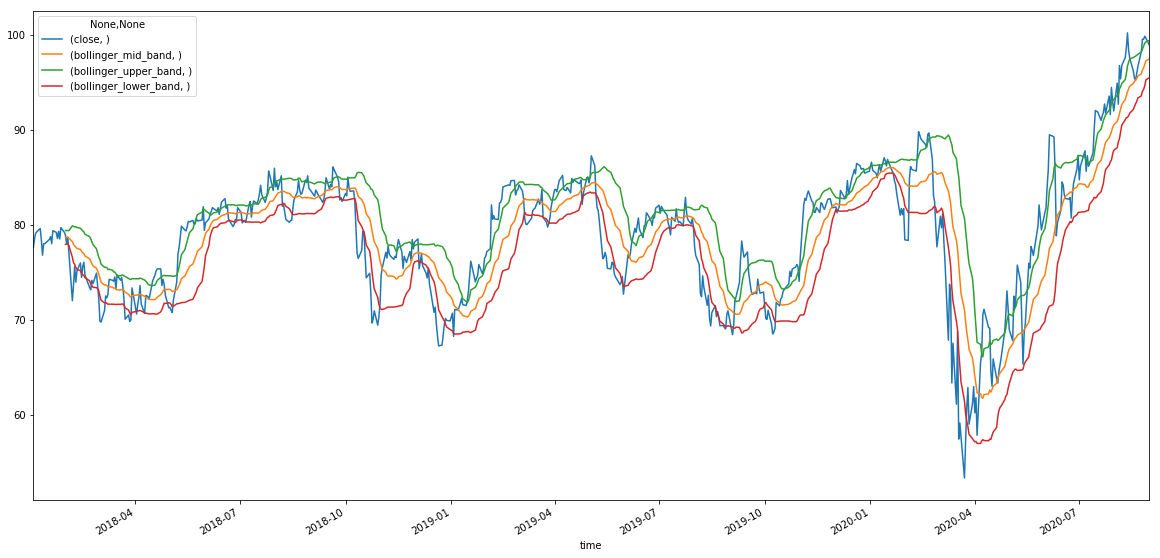

In [15]:
# Plot the Bollinger Bands for BTC/USD closing prices

bol_plot = df[['close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))
bol_plot

In [22]:
#Cleaning the rows that contain NAN

df.isnull().sum()
df_sub=df.dropna()
df_sub.isnull().sum()
df_sub.head()

RBC                                   MA5  \
                            open   high    low   close  volume           
time                                                                     
2019-01-04 00:00:00-05:00  69.23  71.18  68.85  71.090  135442  69.966   
2019-01-07 00:00:00-05:00  71.06  72.10  70.40  71.020   91304  70.184   
2019-01-08 00:00:00-05:00  70.65  71.61  70.50  71.400  228925  70.490   
2019-01-09 00:00:00-05:00  71.49  72.07  70.38  71.760  225013  70.704   
2019-01-10 00:00:00-05:00  71.37  72.30  71.34  72.255  144803  71.505   

                                MA21      MA252       EMA5      EMA21  ...  \
                                                                       ...   
time                                                                   ...   
2019-01-04 00:00:00-05:00  71.595476  77.760040  69.974821  71.393042  ...   
2019-01-07 00:00:00-05:00  71.389286  77.727976  70.323214  71.359129  ...   
2019-01-08 00:00:00-05:00  71.127381  77.696825  70.682143  71.362845  ...   
2019-01-09 00:00:00-05:00  70.939762  77.665714  71.041429  71.398950  ...   
2019-01-10 00:00:00-05:00  70.813333  77.641329  71.445952  71.476772  ...   

                          bollinger_long bollinger_short bollinger_signal  \
                                                                            
time                                                                        
2019-01-04 00:00:00-05:00            0.0             0.0              0.0   
2019-01-07 00:00:00-05:00            0.0             0.0              0.0   
2019-01-08 00:00:00-05:00            0.0             0.0              0.0   
2019-01-09 00:00:00-05:00            0.0             0.0              0.0   
2019-01-10 00:00:00-05:00            0.0             0.0              0.0   

                            close       %K21       %D21       %K63       %D63  \
                                                                                
time                                                                            
2019-01-04 00:00:00-05:00  71.090  39.291711  28.765372  26.389208  20.429067   
2019-01-07 00:00:00-05:00  71.020  44.055573  32.833928  27.593995  21.744841   
2019-01-08 00:00:00-05:00  71.400  47.414006  43.587097  29.962915  27.982039   
2019-01-09 00:00:00-05:00  71.760  51.275437  47.581672  32.779076  30.111995   
2019-01-10 00:00:00-05:00  72.255  55.709014  51.466153  39.081861  33.941284   

                               %K252      %D252  
                                                 
time                                             
2019-01-04 00:00:00-05:00  24.401877  19.188213  
2019-01-07 00:00:00-05:00  24.063954  19.719235  
2019-01-08 00:00:00-05:00  25.898391  24.788074  
2019-01-09 00:00:00-05:00  27.636279  25.866208  
2019-01-10 00:00:00-05:00  30.025875  27.853515  

[5 rows x 29 columns]